In [1]:
import sys
import csv
csv.field_size_limit(sys.maxsize)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve
import scikitplot as skplot

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Basic Match Information (men's) = match_m_df
match_m_df=pd.read_csv("charting-m-matches.csv", engine="python",error_bad_lines=False)
#Points Overview dataframe (men's) = POV_m_df
POV_m_df=pd.read_csv("charting-m-stats-Overview.csv")

Skipping line 514: unexpected end of data


In [3]:
#Match dataframe
print(match_m_df.columns ,len(match_m_df))

Index(['match_id', 'Player 1', 'Player 2', 'Pl 1 hand', 'Pl 2 hand', 'Gender',
       'Date', 'Tournament', 'Round', 'Time', 'Court', 'Surface', 'Umpire',
       'Best of', 'Final TB?', 'Charted by'],
      dtype='object') 512


In [4]:
#New version of match dataframe with only columns I need
match_m_df1=match_m_df[['match_id', 'Player 1', 'Player 2','Gender',
       'Date', 'Tournament', 'Round', 'Time','Surface','Best of']]

In [5]:
print(match_m_df1.columns, len(match_m_df))

Index(['match_id', 'Player 1', 'Player 2', 'Gender', 'Date', 'Tournament',
       'Round', 'Time', 'Surface', 'Best of'],
      dtype='object') 512


In [6]:
#Point overview dataframe
print(POV_m_df.columns,len(POV_m_df.columns))

Index(['match_id', 'player', 'set', 'serve_pts', 'aces', 'dfs', 'first_in',
       'first_won', 'second_in', 'second_won', 'bk_pts', 'bp_saved',
       'return_pts', 'return_pts_won', 'winners', 'winners_fh', 'winners_bh',
       'unforced', 'unforced_fh', 'unforced_bh'],
      dtype='object') 20


In [7]:
#New version of points overview with only columns I need
POV_m_df1=POV_m_df[['match_id','player','set', 'aces', 'dfs', 'first_in',
       'first_won', 'second_in', 'second_won', 'bk_pts', 'bp_saved',
       'return_pts', 'return_pts_won', 'winners','unforced']]
#Take out individual sets and use only the total for the match
POV_m_df1=POV_m_df1.query("set=='Total'")
#Combine stats from players 1 and 2 to get a total for the match 
POV_m_df2=POV_m_df1.groupby(["match_id"], as_index=False).agg("sum")
#Create a total points column, a serve points won column, 
POV_m_df2["total_points"]=POV_m_df2["return_pts"]
POV_m_df2["serve_pts_won"]=POV_m_df2["first_won"]+POV_m_df2["second_won"]

In [8]:
print(POV_m_df2.columns, len(POV_m_df2.columns))

Index(['match_id', 'player', 'aces', 'dfs', 'first_in', 'first_won',
       'second_in', 'second_won', 'bk_pts', 'bp_saved', 'return_pts',
       'return_pts_won', 'winners', 'unforced', 'total_points',
       'serve_pts_won'],
      dtype='object') 16


In [9]:
#Merge dataframes
df=match_m_df1.merge(POV_m_df2, how='inner', on="match_id")
df.iloc[448,8]="Clay"
df.columns

Index(['match_id', 'Player 1', 'Player 2', 'Gender', 'Date', 'Tournament',
       'Round', 'Time', 'Surface', 'Best of', 'player', 'aces', 'dfs',
       'first_in', 'first_won', 'second_in', 'second_won', 'bk_pts',
       'bp_saved', 'return_pts', 'return_pts_won', 'winners', 'unforced',
       'total_points', 'serve_pts_won'],
      dtype='object')

In [10]:
missing_data = df.isna()
missing_data.describe()

,match_id,Player 1,Player 2,Gender,Date,Tournament,Round,Time,Surface,Best of,...,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,unforced,total_points,serve_pts_won
count,510,510,510,510,510,510,510,510,510,510,...,510,510,510,510,510,510,510,510,510,510
unique,1,1,1,1,1,1,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,510,510,510,510,510,510,510,399,510,510,...,510,510,510,510,510,510,510,510,510,510


In [11]:
#Dataset contains info on 510 matches. The matches break down to 
#304 on hard court, 178 on clay and 28 on grass.

In [12]:
#Feature engineering

df["aces_p_set"]=df["aces"]/df["Best of"]
df["dfs_p_set"]=df["dfs"]/df["Best of"]
df["bp_p_set"]=df['bk_pts']/df["Best of"]
df["bp_sav_p_set"]=df['bp_saved']/df["Best of"]
df["winner_p_set"]=df['winners']/df["Best of"]
df["ufe_p_set"]=df['unforced']/df["Best of"]
df["fs_pct"]=df['first_in']/df['total_points']
df["ss_pct"]=df['second_in']/df['total_points']
df["spw_pct"]=df['serve_pts_won']/df['total_points']
df["rpw_pct"]=df['return_pts_won']/df['total_points']
# Clay - 1, Not Clay - 0
df['Clay'] = df['Surface'].map({'Clay': 1, 'Hard': 0, "Grass":0})

# Hard - 0, Not Hard - 1
df['Hard'] = df['Surface'].map({'Clay': 0, 'Hard': 1, "Grass":0})

# Grass- 1, Student Not Grass - 0
df['Grass'] = df['Surface'].map({'Clay': 0, 'Hard': 0, "Grass":1})


In [13]:
df.drop(['Time','Round','Tournament','player','aces', 'dfs',
       'first_in', 'first_won', 'second_in', 'second_won', 'bk_pts',
       'bp_saved', 'return_pts', 'return_pts_won','winners', 'unforced'],axis=1,inplace=True)

In [14]:
df.columns

Index(['match_id', 'Player 1', 'Player 2', 'Gender', 'Date', 'Surface',
       'Best of', 'total_points', 'serve_pts_won', 'aces_p_set', 'dfs_p_set',
       'bp_p_set', 'bp_sav_p_set', 'winner_p_set', 'ufe_p_set', 'fs_pct',
       'ss_pct', 'spw_pct', 'rpw_pct', 'Clay', 'Hard', 'Grass'],
      dtype='object')

In [15]:
y=df[["Clay"]]
y["Clay"].value_counts() / len(df)
x=df.drop(["Clay"],axis=1)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.3)

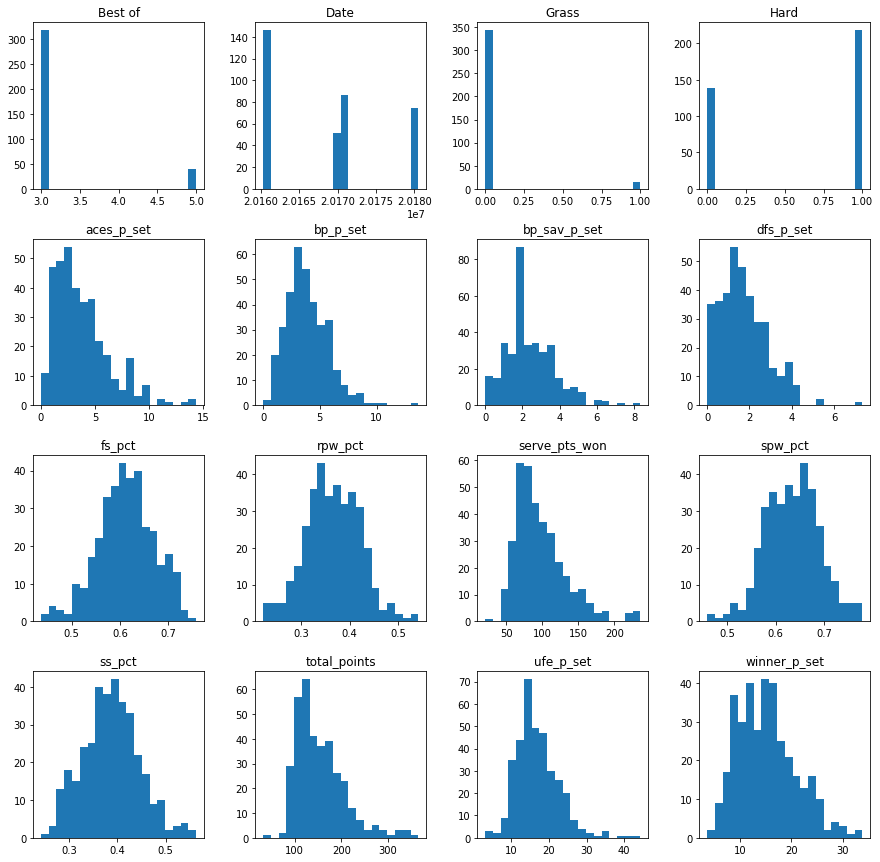

<Figure size 432x288 with 0 Axes>

In [17]:
X_train.hist(bins=20,figsize=(15,15),grid=False)
plt.show()
plt.savefig("histograms.jpg")

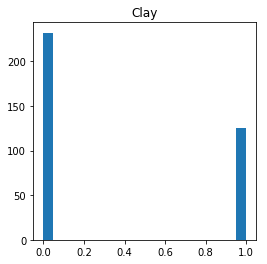

In [18]:
y_train.hist(bins=20,figsize=(4,4),grid=False)
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


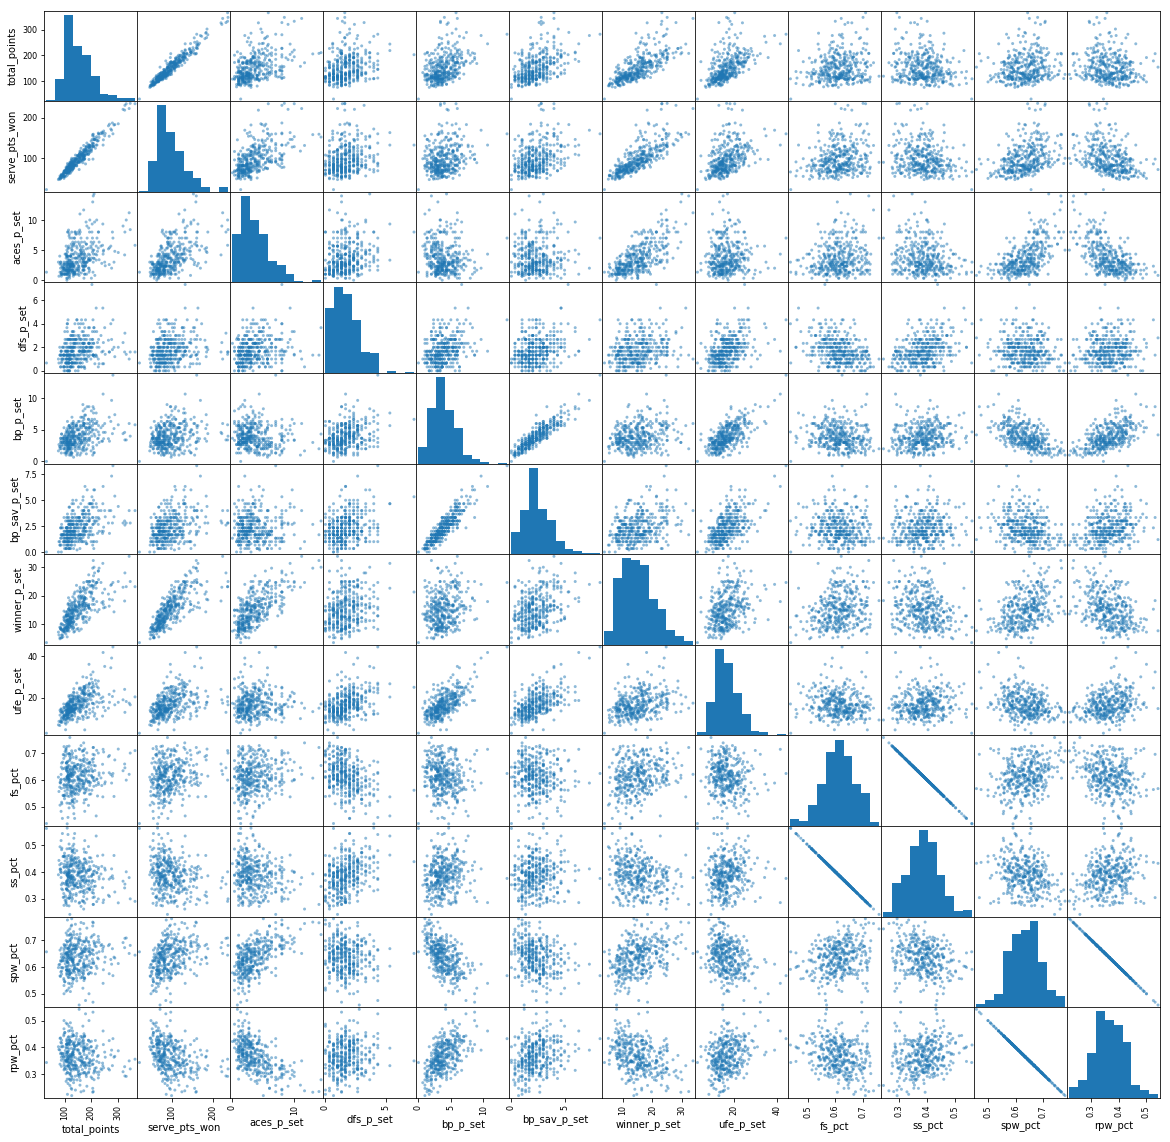

In [19]:
scatter_info=X_train[['total_points', 'serve_pts_won', 'aces_p_set', 'dfs_p_set',
       'bp_p_set', 'bp_sav_p_set', 'winner_p_set', 'ufe_p_set', 'fs_pct',
       'ss_pct', 'spw_pct', 'rpw_pct']]
pd.scatter_matrix(scatter_info, figsize=(20, 20),grid=False)
plt.show()

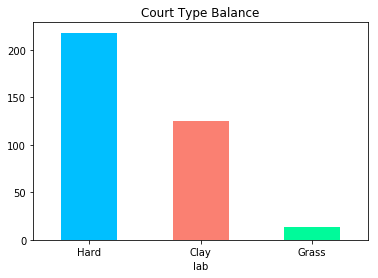

In [20]:
bar_info1 = pd.DataFrame({'lab':['Hard', 'Clay', 'Grass'], 'val':[len(X_train[["Hard"]].query("Hard==1")),len(y_train[["Clay"]].query("Clay==1")),len(X_train[["Grass"]].query("Grass==1"))]})
bar_info1.plot.bar(x='lab', y='val', rot=0,legend=False, title="Court Type Balance",fontsize=10,color=["deepskyblue","salmon","mediumspringgreen"])


In [21]:
print(X_train['Surface'].value_counts() /len(X_train))

Hard     0.610644
Clay     0.350140
Grass    0.039216
Name: Surface, dtype: float64


In [22]:
X_train.columns

Index(['match_id', 'Player 1', 'Player 2', 'Gender', 'Date', 'Surface',
       'Best of', 'total_points', 'serve_pts_won', 'aces_p_set', 'dfs_p_set',
       'bp_p_set', 'bp_sav_p_set', 'winner_p_set', 'ufe_p_set', 'fs_pct',
       'ss_pct', 'spw_pct', 'rpw_pct', 'Hard', 'Grass'],
      dtype='object')

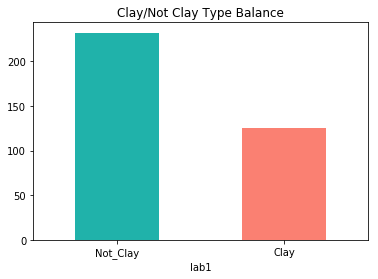

In [23]:
bar_info2 = pd.DataFrame({'lab1':["Not_Clay","Clay"], 'val1':[len(y_train[["Clay"]].query("Clay==0")),len(y_train[["Clay"]].query("Clay==1"))]})
bar_info2.plot.bar(x='lab1', y='val1', rot=0,legend=False, title="Clay/Not Clay Type Balance",fontsize=10,color=["lightseagreen","salmon"])



In [24]:
y_train['Clay'].value_counts() / len(y_train)

0    0.64986
1    0.35014
Name: Clay, dtype: float64

In [25]:
X_mod1 = X_train[['aces_p_set', 'dfs_p_set','bp_p_set', 'winner_p_set', 'ufe_p_set', 'fs_pct', 'rpw_pct']].values
y_mod1 = y_train[["Clay"]].values
y_mod1=y_mod1.ravel()

logit_model1=LogisticRegression().fit(X_mod1, y_mod1)

In [26]:
print(logit_model1.coef_)

[[-0.7272952  -0.30153902 -0.20186376  0.10584234  0.08504496  0.49024884
   0.18057969]]


In [27]:
kfold1 = KFold(len(y_train))
 
accuracies1 = []
precisions1 = []
recalls1 = []
 
for train_index, test_index in kfold1:
    model = LogisticRegression()
    model.fit(X_mod1[train_index], y_mod1[train_index])
    y_predict = model.predict(X_mod1[test_index])
    y_true = y_mod1[test_index]
    accuracies1.append(accuracy_score(y_true, y_predict))
    precisions1.append(precision_score(y_true, y_predict))
    recalls1.append(recall_score(y_true, y_predict))

print ("accuracy:", np.average(accuracies1))
print ("precision:", np.average(precisions1))
print ("recall:", np.average(recalls1))

accuracy: 0.7198879551820728
precision: 0.6183672276764843
recall: 0.5363962941955002


In [28]:
X_mod2 = X_train[['aces_p_set', 'dfs_p_set', 'winner_p_set', 'fs_pct', 'rpw_pct']].values
y_mod2 = y_train[["Clay"]].values
 
logit_model2 = LogisticRegression().fit(X_mod2,y_mod2.ravel())

In [29]:
logit_model2.coef_

array([[-0.69527227, -0.21483811,  0.11598501,  0.60003893,  0.14277886]])

In [30]:
kfold2 = KFold(len(y_train))
 
accuracies2 = []
precisions2 = []
recalls2 = []
 
for train_index, test_index in kfold2:
    model = LogisticRegression()
    model.fit(X_mod2[train_index], y_mod2[train_index])
    y_predict = model.predict(X_mod2[test_index])
    y_true = y_mod2[test_index]
    accuracies2.append(accuracy_score(y_true, y_predict))
    precisions2.append(precision_score(y_true, y_predict))
    recalls2.append(recall_score(y_true, y_predict))

print ("accuracy:", np.average(accuracies2))
print ("precision:", np.average(precisions2))
print ("recall:", np.average(recalls2))


accuracy: 0.7226890756302522
precision: 0.6346109175377469
recall: 0.5208924182265079


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
X_mod3 = X_train[['aces_p_set', 'dfs_p_set', 'winner_p_set', 'fs_pct', 'rpw_pct']].values
y_mod3 = y_train[["Clay"]].values
 
logit_model3 = LogisticRegression(class_weight='balanced').fit(X_mod3,y_mod3.ravel())

In [32]:
logit_model3.coef_

array([[-0.6832429 , -0.20208324,  0.1141521 ,  0.82334484,  0.29976899]])

In [33]:
kfold3 = KFold(len(y_train))
 
accuracies3 = []
precisions3 = []
recalls3 = []
 
for train_index, test_index in kfold3:
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_mod3[train_index], y_mod3[train_index])
    y_predict = model.predict(X_mod3[test_index])
    y_true = y_mod3[test_index]
    accuracies3.append(accuracy_score(y_true, y_predict))
    precisions3.append(precision_score(y_true, y_predict))
    recalls3.append(recall_score(y_true, y_predict))

print ("accuracy:", np.average(accuracies3))
print ("precision:", np.average(precisions3))
print ("recall:", np.average(recalls3))

accuracy: 0.6750700280112044
precision: 0.5308641975308642
recall: 0.7347324636037058


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
y_predict = logit_model3.predict(X_test[['aces_p_set', 'dfs_p_set', 'winner_p_set', 'fs_pct', 'rpw_pct']])
y_true = y_test
print(f"TEST SET ACCURACY: {accuracy_score(y_true, y_predict)}")
print(f"TEST SET PRECISION: {precision_score(y_true, y_predict)}")
print(f"TEST SET RECALL:{recall_score(y_true, y_predict)}")

TEST SET ACCURACY: 0.673202614379085
TEST SET PRECISION: 0.5180722891566265
TEST SET RECALL:0.8113207547169812


In [35]:
tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
con_mat=np.array([[tp,fn],[fp,tn]])
con_mat

array([[43, 10],
       [40, 60]])

In [43]:
# bar_info1 = pd.DataFrame({'x':['True_Pos', 'False_Neg', 'True_Neg',"False_Pos"], 'val':[tp,fn,tn,fp]})
# bar_info1.plot.bar(x='x', y='val', rot=0,legend=False, title="Confusion Matrix",fontsize=10,color=["Blue","Red","Blue","Red"])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[60 40]
 [10 43]]


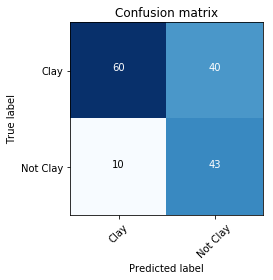

In [44]:
plot_confusion_matrix(confusion_matrix(y_true, y_predict),["Clay","Not Clay"])

In [45]:
y_hats_test=logit_model3.predict_proba(X_test[['aces_p_set', 'dfs_p_set', 'winner_p_set', 'fs_pct', 'rpw_pct']].values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


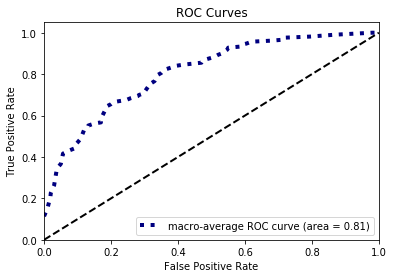

In [46]:
skplot.metrics.plot_roc_curve(y_test, y_hats_test, curves='macro')